In [81]:
# Imports
import glob, sys, os
import numpy as np
# Plotting Stuff
from matplotlib import pyplot as plt
import matplotlib as mpl
import mplhep as hep
plt.style.use(hep.style.CMS)
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = r'\usepackage[cm]{sfmath}'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'
# Various utils
import uproot
import torch
from torch.utils.data import DataLoader
from modeloss.pytorch import MoDeLoss
from util.loss import MSE, DiscoLoss
from util.utils import DataSet, swish, Metrics
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [82]:
class MLP(torch.nn.Module): # Model from utils
    def __init__(self,input_size=10,out_channels=1, readout_activation=None,name=None):
        """
         DNN Model inherits from torch.torch.nn.Module. Can be initialized with input_size: Number of features per sample.

        This is a class wrapper for a simple DNN model. Creates an instance of torch.torch.nn.Module that has 4 linear layers. Use torchsummary for details.abs

        Parameters
        ----------
        input_size : int=10
            The number of features to train on.
        name : string=None
            Specifiy a name for the Dtorch.nn.break
        """
        super().__init__()
        self.linear = torch.nn.Linear(input_size,64,bias=False)
        self.linear1 = torch.nn.Linear(64,64,)
        self.linear2 = torch.nn.Linear(64,64)
        self.batchnorm = torch.nn.BatchNorm1d(64)
        self.out = torch.nn.Linear(64,out_channels)
        # Defaults
        self.out_channels = out_channels
        self.readout_activation = readout_activation 
        self.yhat_val = None
        self.yhat = None
        self.name = name
    def forward(self, x):
        x = swish(self.linear(x))
        x = self.batchnorm(x)
        x = swish(self.linear1(x))
        x = swish(self.linear2(x))
        x = self.out(x)
        if self.readout_activation is not None:
            x = self.readout_activation(x)
        return x 
def find_threshold(L,mask,x_frac):
    """
    Calculate c such that x_frac of the array is less than c. Used to calcuate the cut for a given signal efficiency for example.

    Parameters
    ----------
    L : Array
        The array where the cutoff is to be found
    mask : Array,
        Mask that returns L[mask] the part of the original array over which it is desired to calculate the threshold.
    x_frac : float
        Of the area that is lass than or equal to c.

    returns c (type=L.dtype)
    """
    max_x = mask.sum()
    x = int(np.round(x_frac * max_x))
    L_sorted = np.sort(L[mask.astype(bool)])
    return L_sorted[x]
def selection(iData):
        #lets apply a trigger selection
        trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() > 0)
        #Now lets require the jet pt to be above a threshold
        jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() > 400)
        #Lets apply both jetpt and trigger at the same time
        #standard_trig = (iData.arrays('trigger', library="np")["trigger"].flatten() % 4 > 1) #lets require one of our standard triggers (jet pT > 370 )
        allcuts = np.logical_and.reduce([trigger,jetpt])
        return allcuts

In [3]:
# Load Data
wqq    = uproot.open("data/WQQ_s.root")["Tree"]
zqq    = uproot.open("data/ZQQ_s.root")["Tree"]
wqq13  = uproot.open("data/skimh/WQQ_sh.root")["Tree"]
zqq13  = uproot.open("data/skimh/ZQQ_sh.root")["Tree"]
qcd    = uproot.open("data/QCD_s.root")["Tree"]
data   = uproot.open("data/JetHT_s.root")["Tree"]
ggh    = uproot.open("data/ggH.root")["Tree"]
tt     = uproot.open("data/TT.root")["Tree"]
ww     = uproot.open("data/WW.root")["Tree"]
wz     = uproot.open("data/WZ.root")["Tree"]
zz     = uproot.open("data/ZZ.root")["Tree"]
datasel = selection(data)
wsel = selection(wqq13)
zsel = selection(zqq13)
qcdsel = selection(qcd)
wwsel = selection(ww)
zzsel = selection(zz)
ttsel = selection(tt)
wzsel = selection(wz)
gghsel = selection(ggh)

In [4]:
#This computs the integral of weighted events assuming a selection given by the function selection(see below)
def integral(iData,iWeights):
    #perform a selection on the data (
    mask_sel=selection(iData)
    #now iterate over the weights not the weights are in the format of [number,variable name 1, variable name 2,...]
    weight  =iWeights[0]
    for i0 in range(1,len(iWeights)):
        weightarr = iData.arrays(iWeights[i0], library="np")[iWeights[i0]][mask_sel].flatten()
        #multiply the weights
        weight    = weight*weightarr
    #now take the integral and return it
    return np.sum(weight)
def scale(iData8TeV,iData13TeV,iWeights):
    int_8TeV  = integral(iData8TeV,iWeights)
    int_13TeV = integral(iData13TeV,iWeights)
    print("Scale:",int_8TeV/int_13TeV,int_8TeV,int_13TeV)
    return int_8TeV/int_13TeV
def get_weights(weights,mask,sel=None,check=None):
    weight = weights[0]
    for i in range(1,len(weights)):
        if check is None:
            weight *= np.concatenate([wqq13.arrays(weights[i], library="np")[weights[i]][wsel],
                        qcd.arrays(weights[i], library="np")[weights[i]][qcdsel]])[mask]
        else:
            weight *= check.arrays(weights[i], library="np")[weights[i]][sel][mask]
    return weight

In [5]:
# Get features
def keep_key(key):
    kws = ["gen", "mass", "msd0", "msd1", "flavor", "mprune", "mtrim", "trig", "qgid", "iso", "pt", "eta", "phi"] #Trig actually pretty useful
    for kw in kws:
        if kw in key: return False
    return True
keys = [] #keys = ["vjet0_msd0"]
keys+= [key for key in qcd.keys() if key.startswith("vjet0") and  keep_key(key)]
#keys += ["trigger", "puweight", "nvtx", "rho", "metRaw", "metRawPhi", "met", "mvamet", "puppet", "njets"]
bkg = np.stack(list(qcd.arrays(keys, library="np").values()), axis=-1)[qcdsel]
sig = np.stack(list(wqq13.arrays(keys, library="np").values()), axis=-1)[wsel]
data_samples = np.stack(list(data.arrays(keys, library="np").values()), axis=-1)[datasel]
z_samples = np.stack(list(zqq13.arrays(keys, library="np").values()), axis=-1)[zsel]
zz_samples = np.stack(list(zz.arrays(keys, library="np").values()), axis=-1)[zzsel]
wz_samples = np.stack(list(wz.arrays(keys, library="np").values()), axis=-1)[wzsel]
ww_samples = np.stack(list(ww.arrays(keys, library="np").values()), axis=-1)[wwsel]
tt_samples = np.stack(list(tt.arrays(keys, library="np").values()), axis=-1)[ttsel]
ggh_samples = np.stack(list(ggh.arrays(keys, library="np").values()), axis=-1)[gghsel]
print("Used features:")
print(*keys, sep=" | ")

Used features:
vjet0_csv | vjet0_t1 | vjet0_t2 | vjet0_t3 | vjet0_pullAngle | vjet0_sj1_csv | vjet0_sj2_csv | vjet0_sj1_q | vjet0_sj2_q | vjet0_sj1_z | vjet0_sj2_z | vjet0_c2b0 | vjet0_c2b0P2 | vjet0_c2b0P5 | vjet0_c2b1P0 | vjet0_c2b2P0 | vjet0_qjet


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


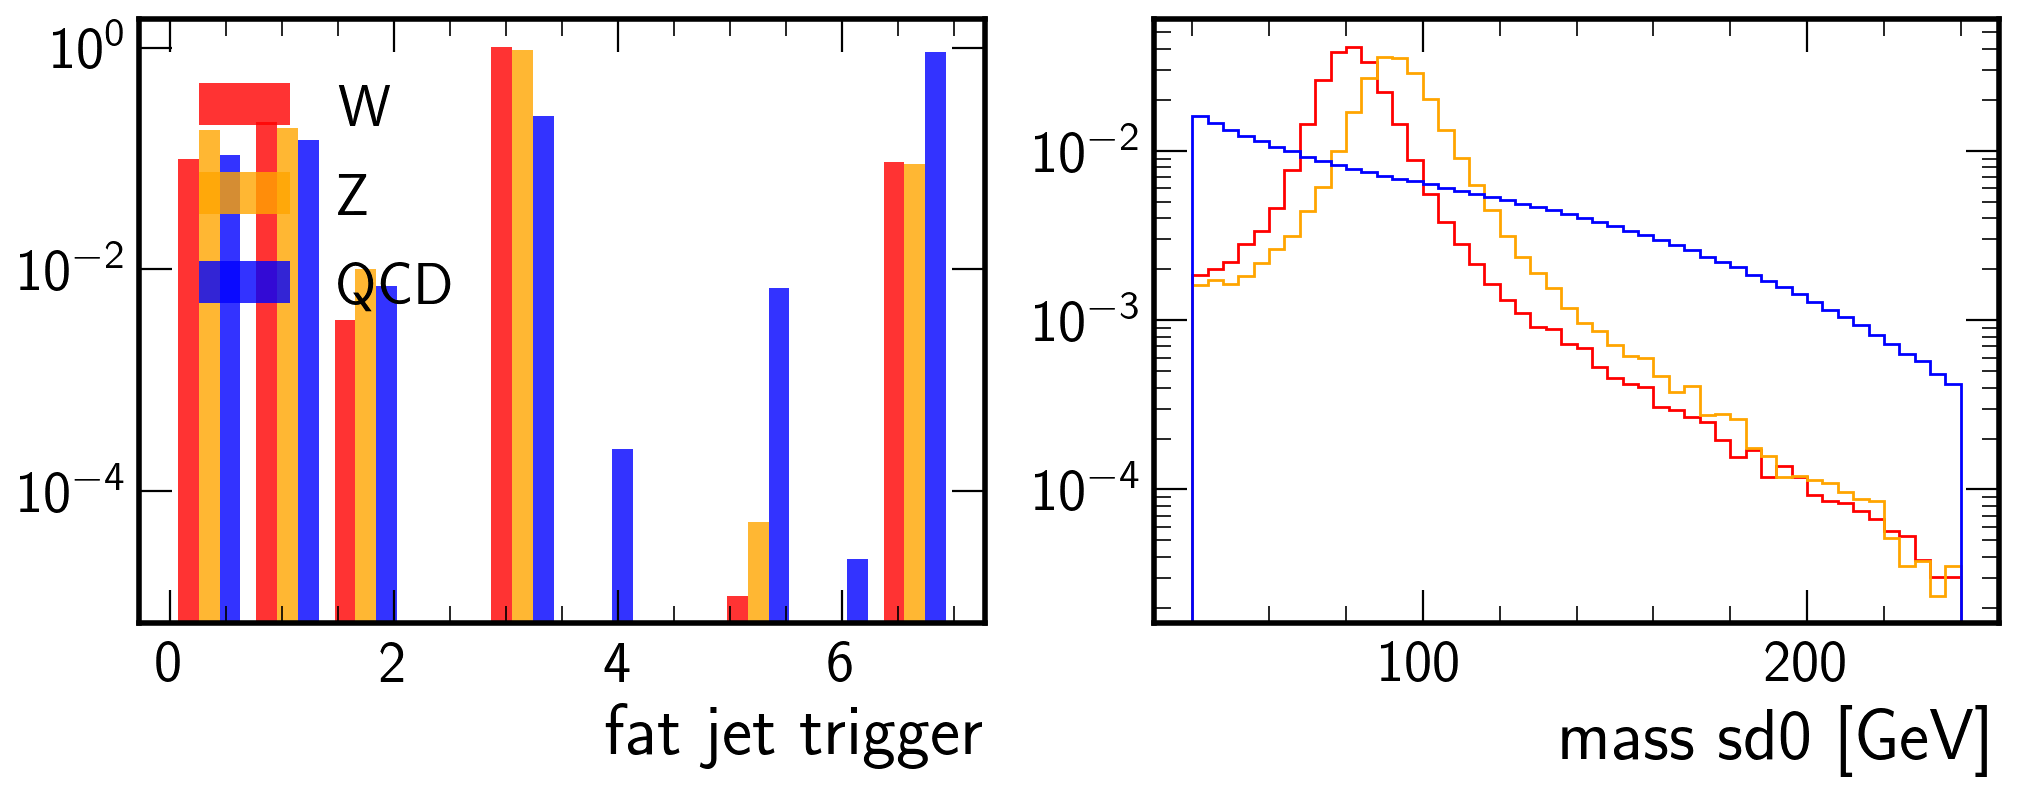

In [83]:
#plot
fig,(ax,ax1) = plt.subplots(1,2,dpi=200,figsize=(12,4))
ax.hist([wqq13.arrays("vjet0_trig", library="np")["vjet0_trig"],
         zqq13.arrays("vjet0_trig", library="np")["vjet0_trig"],
         qcd.arrays("vjet0_trig", library="np")['vjet0_trig']],
         density=True, label=["W","Z","QCD"], color=["r","orange","b"], alpha=0.8
        )
ax.legend(loc="upper left")
ax.set_yscale("log")
ax.set_xlabel("fat jet trigger")
ax1.hist(wqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"], color="r", bins=50, range=(40,240), density=True, histtype="step")
ax1.hist(zqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"], color="orange", bins=50, range=(40,240), density=True, histtype="step")
ax1.hist(qcd.arrays("vjet0_msd0", library="np")['vjet0_msd0'], color="b", bins=50, range=(40,240), density=True, histtype="step") 
ax1.set_xlabel("mass sd0 [GeV]")
ax1.set_yscale("log")

In [7]:
labels = np.concatenate([np.zeros(len(sig)),np.ones(len(bkg))])
samples = np.concatenate([sig,bkg],axis=0).astype("float32")
maxsamples = samples.max(axis=0)
minsamples = samples.min(axis=0)
samples = (samples-minsamples)/(maxsamples-minsamples)
data_samples = data_samples.astype("float32")
data_samples = (data_samples-minsamples)/(maxsamples-minsamples)
data_mass = data.arrays("vjet0_msd0", library="np")["vjet0_msd0"][datasel]
z_samples = z_samples.astype("float32")
z_samples = (z_samples-minsamples)/(maxsamples-minsamples)
z_mass = zqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"][zsel]
zz_samples = zz_samples.astype("float32")
zz_samples = (zz_samples-minsamples)/(maxsamples-minsamples)
zz_mass = zz.arrays("vjet0_msd0", library="np")["vjet0_msd0"][zzsel]
ww_samples = ww_samples.astype("float32")
ww_samples = (ww_samples-minsamples)/(maxsamples-minsamples)
ww_mass = ww.arrays("vjet0_msd0", library="np")["vjet0_msd0"][wwsel]
wz_samples = wz_samples.astype("float32")
wz_samples = (wz_samples-minsamples)/(maxsamples-minsamples)
wz_mass = wz.arrays("vjet0_msd0", library="np")["vjet0_msd0"][wzsel]
tt_samples = tt_samples.astype("float32")
tt_samples = (tt_samples-minsamples)/(maxsamples-minsamples)
tt_mass = tt.arrays("vjet0_msd0", library="np")["vjet0_msd0"][ttsel]
ggh_samples = ggh_samples.astype("float32")
ggh_samples = (ggh_samples-minsamples)/(maxsamples-minsamples)
ggh_mass = ggh.arrays("vjet0_msd0", library="np")["vjet0_msd0"][gghsel]
#samples[::,0] = 2*(samples[::,0]-samples[:,0].min())/(samples[:,0].max()-samples[:,0].min())-1
mass = np.concatenate([wqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"][wsel],
                    qcd.arrays("vjet0_msd0", library="np")["vjet0_msd0"][qcdsel]]).astype("float32")              
m = 2*(mass-mass.min())/(mass.max()-mass.min())-1

In [8]:
torch.random.manual_seed(42)
labels_ = labels#[:10*len(sig)]
weights = np.zeros_like(labels_)
weights[labels_==0] = get_class_weights(labels_)[0]
weights[labels_==1] = get_class_weights(labels_)[1]
dataset = DataSet(samples=samples,
                       labels=labels_,
                       weights=weights,
                       m = m)
traindataset, valdataset = torch.utils.data.random_split(dataset,[len(labels_)-len(sig),len(sig)])
trainloader = torch.utils.data.DataLoader(traindataset,num_workers=6,
                                          batch_size=256*16,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valdataset,num_workers=6,
                                          batch_size=256*16,
                                          shuffle=False)

#X = torch.from_numpy(samples[2*len(sig):,:]).float()#.to(device)

In [9]:
# Testing data and Plotting
test_mass = mass[valdataset.indices]
test_labels = dataset[valdataset.indices][1]
test = torch.from_numpy(dataset.samples[valdataset.indices])
def plot_hists(scores,test_mass=test_mass,test_labels=test_labels,
               c="w",label=None,lw=None,plot_path=None,dpi=200,show=False,transparent=None, density=True):
    cut = find_threshold(scores,(test_labels==0),.5)
    # sig_bkg
    fig, ax= plt.subplots(1,1,figsize=(4,3.6),dpi=dpi)
    w,bins = np.histogram(test_mass[test_labels==1],bins=80,density=False)
    #plt.hist(bins[:-1],bins=bins,weights=w,histtype="step",label="Before selection",color="darkred",ls="-")
    false_signal = test_mass[(test_labels==1)&(scores<cut)]
    w_bkg,bins = np.histogram(false_signal,bins=bins)
    true_signal = test_mass[(test_labels==0)&(scores<cut)]
    w_sig,bins = np.histogram(true_signal,bins=bins)
#     plt.hist(bins[:-1],bins=bins,weights=w_bkg,density=density,histtype="step",label=label.strip()+" bkg",color=c,lw=lw)
#     plt.hist(bins[:-1],bins=bins,weights=w_sig,density=density,histtype="step",label=label.strip()+" sig",color="r",lw=lw)
    plt.hist(test_mass[(test_labels==0)&(scores<cut)],bins=80,density=density,histtype="step",label="selected sig",color="r",lw=lw)
    plt.hist(test_mass[(test_labels==1)&(scores<cut)],bins=80,density=density,histtype="step",label="selected bkg",color="b",lw=lw)
    plt.hist(test_mass[test_labels==0],bins=80,density=density,histtype="step",label="Signal",color="r",ls="--",alpha=.75)
    plt.hist(test_mass[test_labels==1],bins=80,density=density,histtype="step",label="Background",color="b",ls="--",alpha=.75)
    plt.legend(loc='upper right',fontsize=12,ncol=1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([40,240])
    #plt.ylim([2e-6,1e-1])
    plt.yscale("log")
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    ax.set_xlabel("Mass [GeV]",fontsize=14)
    ax.set_ylabel("Counts",fontsize=14)
    fig.tight_layout(pad=0)
    #plt.title("Distributions of Predicted Background")
    #plt.savefig(plot_path.format("selectedbkg_sans"))
    if plot_path is not None: plt.savefig(plot_path,transparent=transparent)
    #if show: 
        #plt.show()
        #plt.close()
    return fig,ax 
def plot_lines(scores, test_mass=test_mass, test_labels=test_labels,
               plot_path=None,show=False,mbins=100,histbins=None,dpi=200,ncuts=9,transparent=None,
               ptype=0,dynamicbins=True,scale=None,xlim=None,legend_ncol=3,cmap=plt.cm.viridis, ylim=[-0.02,1.02]):
    if histbins == None:
        histbins=mbins

    fig, ax1= plt.subplots(1,1,figsize=(8,4),dpi=dpi)
    efficiencies = np.linspace(0.1,0.9,ncuts)[::-1]
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(scores,(test_labels==0),eff))
    m = test_mass[test_labels==1]
    scores_ = scores[test_labels==1]
    if dynamicbins:
        mod = len(test_mass)%mbins
        if mod!=0:
            m = m[:-mod]
            scores_ = scores_[:-mod]
        sorted_m = np.argsort(m)
        scores_ = scores_[sorted_m].reshape(mbins,-1)
        m = m[sorted_m]
        m = m.reshape(mbins,-1).mean(axis=1)
    else:
        _,bins = np.histogram(m,bins=mbins)
        digitized = np.digitize(m,bins)
        m = (bins[:-1] + bins[1:])*0.5
    for j,cut in enumerate(cuts):
        c = cmap(j/ncuts)#f"C{j}" #if j!= 6 else f"C11"
        if dynamicbins:
            passed = (scores_<cut).sum(axis=1)/scores_.shape[1]
        else:
            passed = [(scores_[digitized==i+1]<cut).sum()/(digitized==i+1).sum() for i in range(mbins)]
        if ptype == 0:
            ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
        else:
            ax1.step(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
    if scale is not None:
        ax1.set_yscale(scale)        
    ax1.set_ylabel("False Pos. Rate",fontsize=14)
    ax1.set_ylim(ylim)
    if xlim: ax1.set_xlim(xlim)
    if legend_ncol>0:
        ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,
                   title="SE (Cut)",ncol=legend_ncol,fontsize=12)
    ax1.set_xlabel("Mass [GeV]",fontsize=14)
    fig.tight_layout(pad=0)
    if plot_path is not None:
        fig.savefig(plot_path,transparent=transparent)
    plt.show()
    return

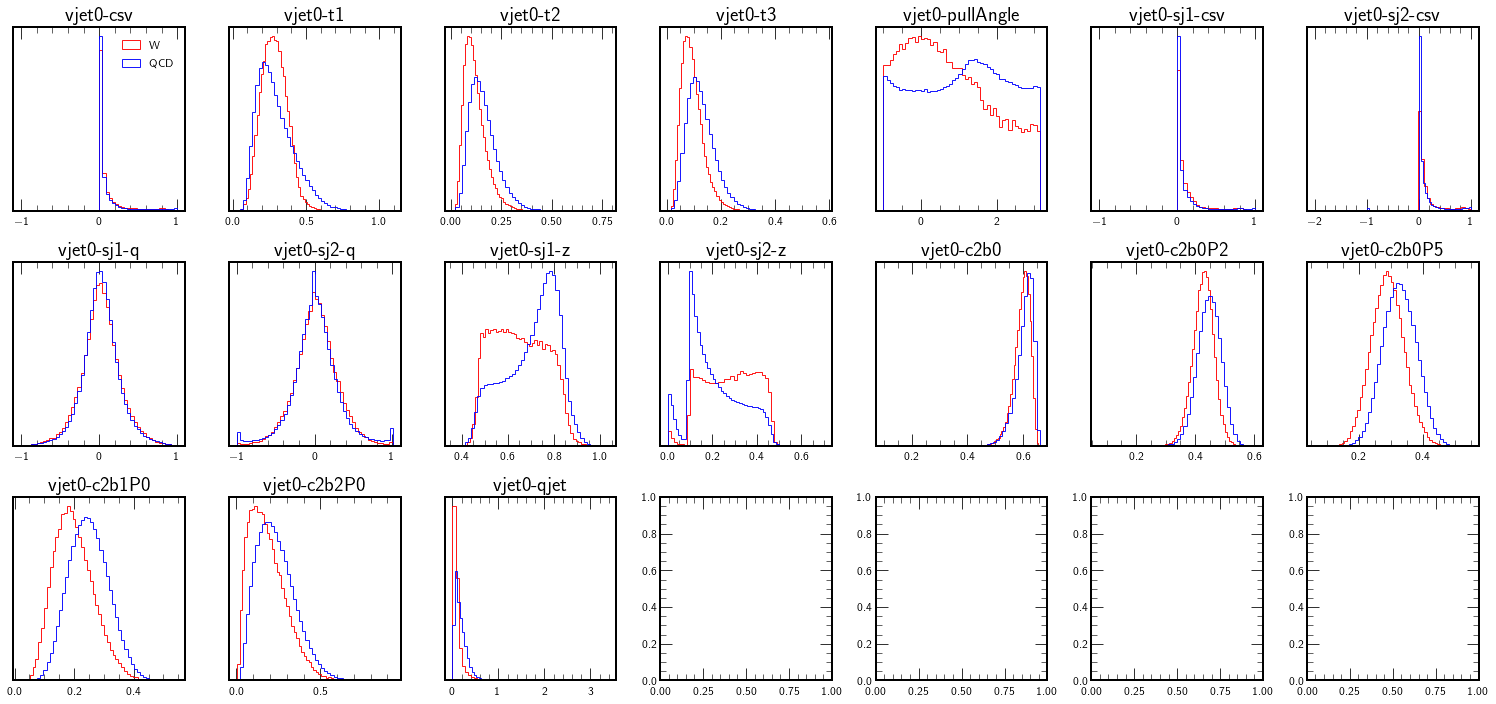

In [10]:
# plotting features
fig, axes = plt.subplots(3,7,figsize=(21,10))
histtype='step'
for i,ax in enumerate(axes.flatten()):
    try:
        bkg_min = bkg[:,i].min() if bkg[:,i].min()>-10 else -1
        sig_min = sig[:,i].min() if sig[:,i].min()>-10 else -1
        ax.hist(sig[:,i],bins=50,range=[sig_min,sig[:,i].max()],alpha=0.9, color="r",label='W',histtype=histtype, density=True)
        ax.hist(bkg[:,i],bins=50,range=[bkg_min,bkg[:,i].max()],alpha=0.9, color="b",label='QCD',histtype=histtype, density=True)
    except IndexError:
        continue
    ax.set_title("-".join(keys[i].split("_")))
    ax.set_yticks([])
    if i==0: ax.legend()
    fig.tight_layout()

In [11]:
logdir = "./lightning_logs/W-tag/4096/"
if not os.path.exists(logdir): os.makedirs(logdir,exist_ok=True)
with open(os.path.join(logdir, "features.txt"), "w") as f:
    f.writelines("\n".join(keys))
epochs = 30
lr = 1e-3
optim = torch.optim.Adam
#Loss = torch.nn.BCELoss()

# Unconstrained

In [12]:
# Train the NN 
module = Model3(dataset.samples.shape[1]) #readout_activation = torch.sigmoid)
lcn = Model(module, optim=optim(module.parameters(),lr=lr))
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="unconstrained",default_hp_metric=False)
path = os.path.join(logdir,f"unconstrained/version_{log.version}")
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(lcn,train_dataloader=trainloader,val_dataloaders=valloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Model3 | 9.6 K 


Epoch 29: 100%|##########| 587/587 [00:07<00:00, 81.14it/s, loss=0.145, v_num=8, val_loss=0.157, val_acc=0.825]


1

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


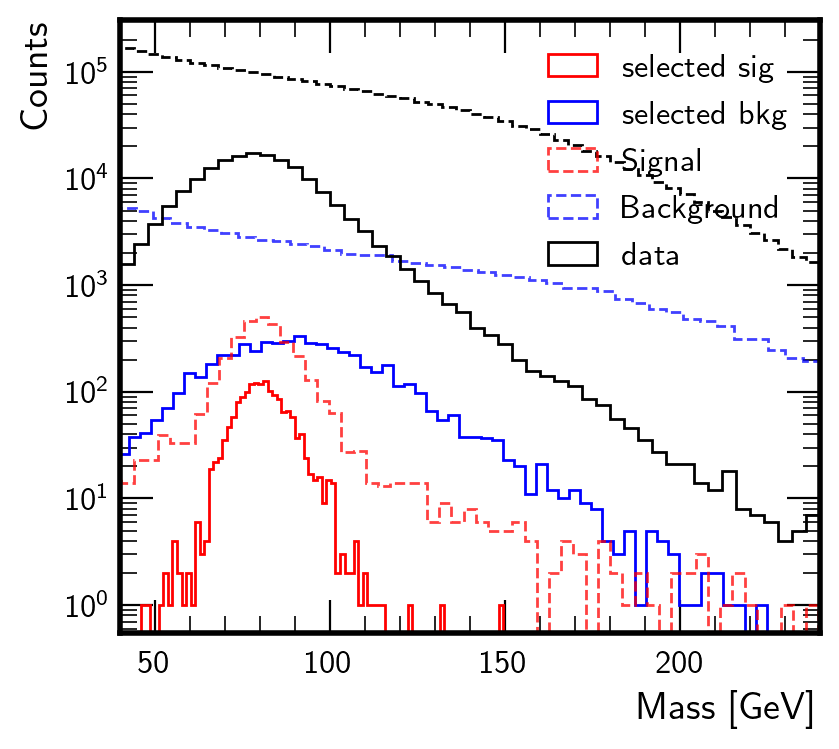

In [13]:
with torch.no_grad():
    module.eval()
    scores = torch.sigmoid(module(test)).numpy().flatten()
    data_scores = torch.sigmoid(module(torch.from_numpy(data_samples))).numpy().flatten()
fig, ax = plot_hists(scores,c="royalblue",label="Selected",lw=None,show=True,dpi=200,transparent=False,density=False)
cut = find_threshold(scores,(test_labels==0),.5)
ax.hist(data_mass, histtype="step",color="k",bins=50,range=(40,240),density=False,ls="--")
ax.hist(data_mass[data_scores<cut], histtype="step",color="k",bins=50,range=(40,240),density=False, label="data")
plt.legend()
plt.show()

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered i

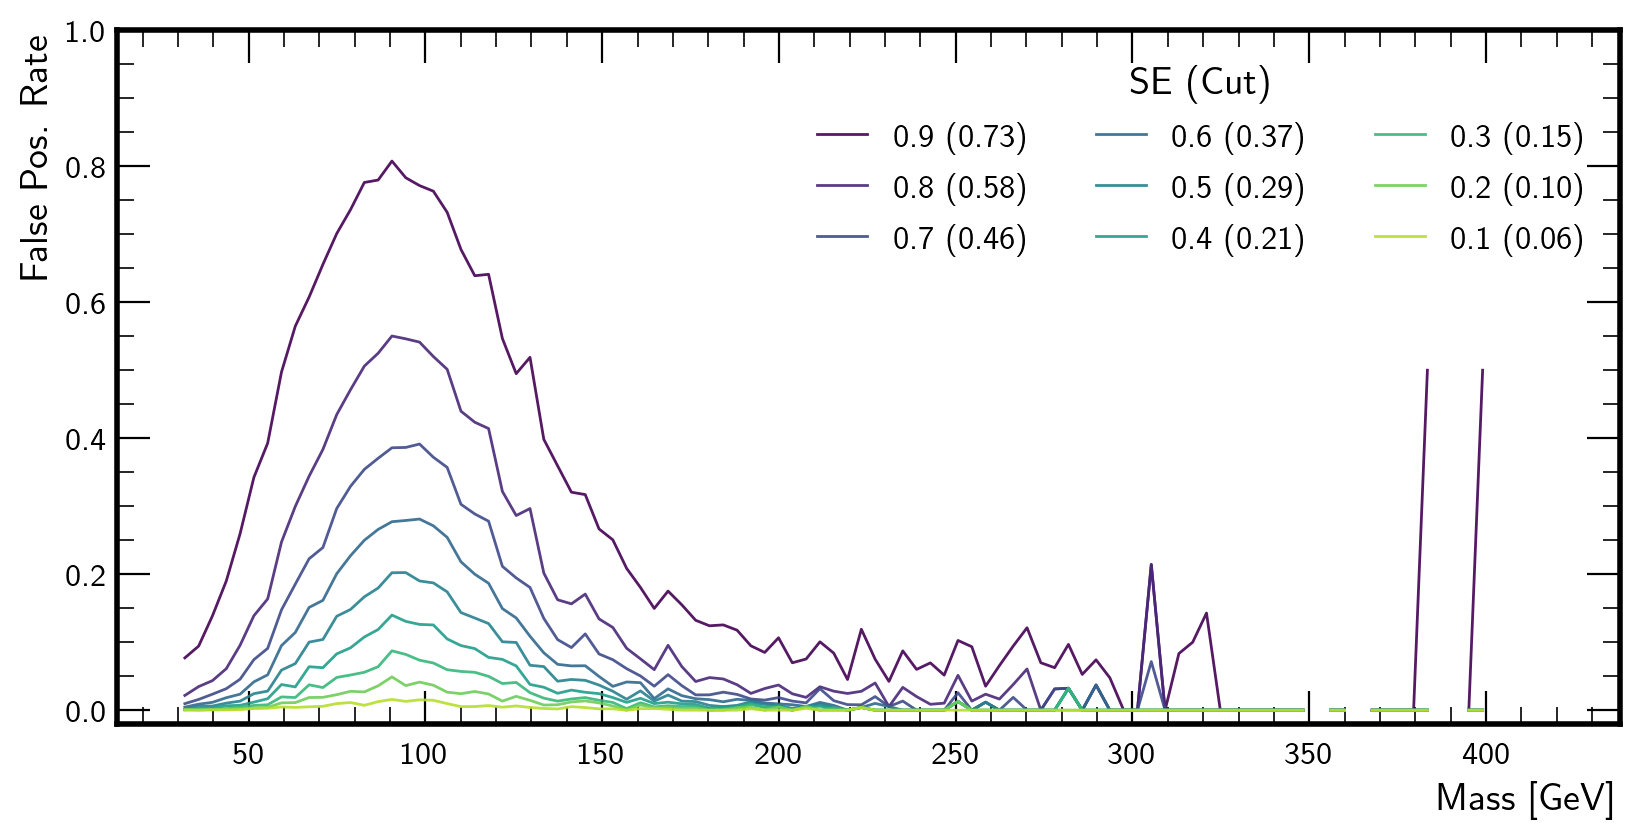

In [14]:
plot_lines(scores,plot_path=None,show=False,mbins=100,histbins=None,dpi=200,ncuts=9,transparent=None,
           ptype=0,dynamicbins=False,scale=None,xlim=None,ylim=[-.02,1],legend_ncol=3,cmap=plt.cm.viridis)

0.5765707


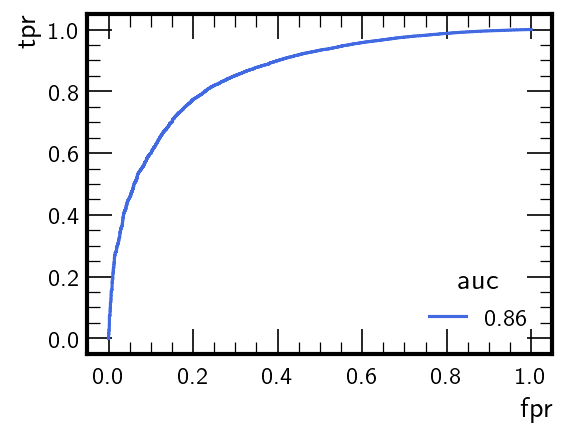

In [15]:
auc = roc_auc_score(y_score=scores, y_true=test_labels)
fpr, tpr, cuts = roc_curve(y_score=scores, y_true=test_labels)
print(cuts[(tpr-fpr).argmax()])
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
plt.plot(fpr, tpr,label=f"{auc:.2f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(title="auc")

# MoDe

In [16]:
mode0 = MoDeLoss(bins=32,
    sbins=32,
    memory=False,
    background_label=1,
    background_only=True,
    power=2,
    order=0,
    lambd=None,
    max_slope=None,
    monotonic=False,
    eps=0.0001,
    dynamicbins=True,
    normalize=True,
    sign_func='tanh')

In [17]:
# Train the NN 
module0 = Model3(dataset.samples.shape[1]) #readout_activation = torch.sigmoid)
model = Model(module0, optim=optim(module0.parameters(),lr=lr), regularization=100, regularizer = mode0)
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="mode0",default_hp_metric=False)
path = os.path.join(logdir,f"mode0/version_{log.version}")
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(model,train_dataloader=trainloader,val_dataloaders=valloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Model3 | 9.6 K 


Epoch 29: 100%|##########| 587/587 [00:09<00:00, 62.57it/s, loss=0.246, v_num=7, val_loss=0.231, val_acc=0.932, val_loss_reg=0.0121] 


1

(<Figure size 800x720 with 1 Axes>,
 <AxesSubplot:xlabel='Mass [GeV]', ylabel='Counts'>)

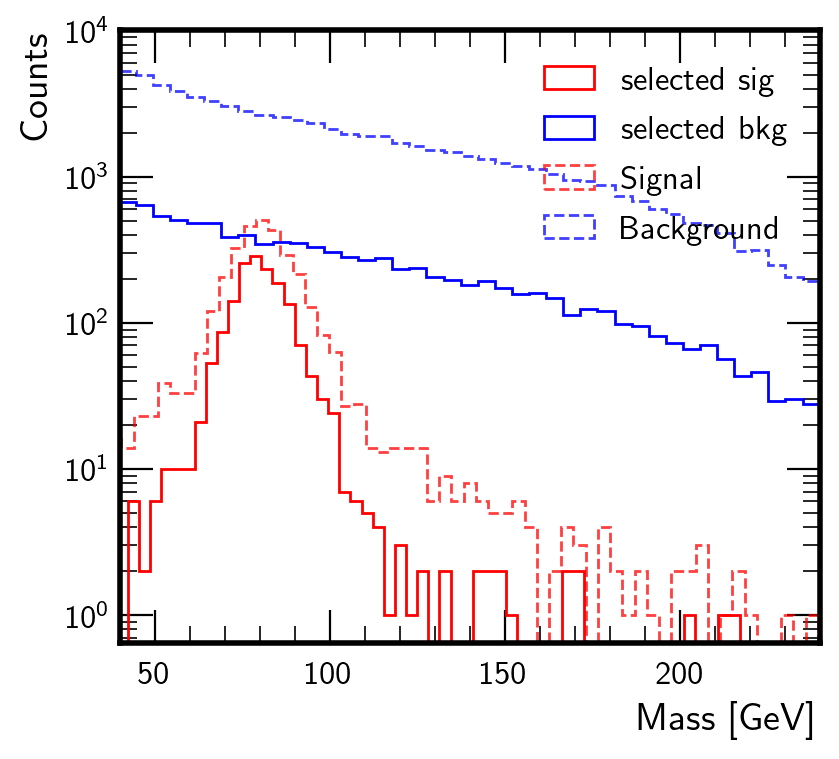

In [18]:
with torch.no_grad():
    module0.eval()
    scores0 = torch.sigmoid(module0(test)).numpy().flatten()
cmap = plt.cm.coolwarm
plot_hists(scores0,c="royalblue",label="Selected",lw=None,show=True,dpi=200,transparent=False,density=False)
# plot_lines(scores,show=True,mbins=100,histbins=None,ncuts=13,dpi=200,transparent=False,
#        ptype=0,dynamicbins=True,scale=None,xlim=None,legend_ncol=0,cmap=cmap)

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered i

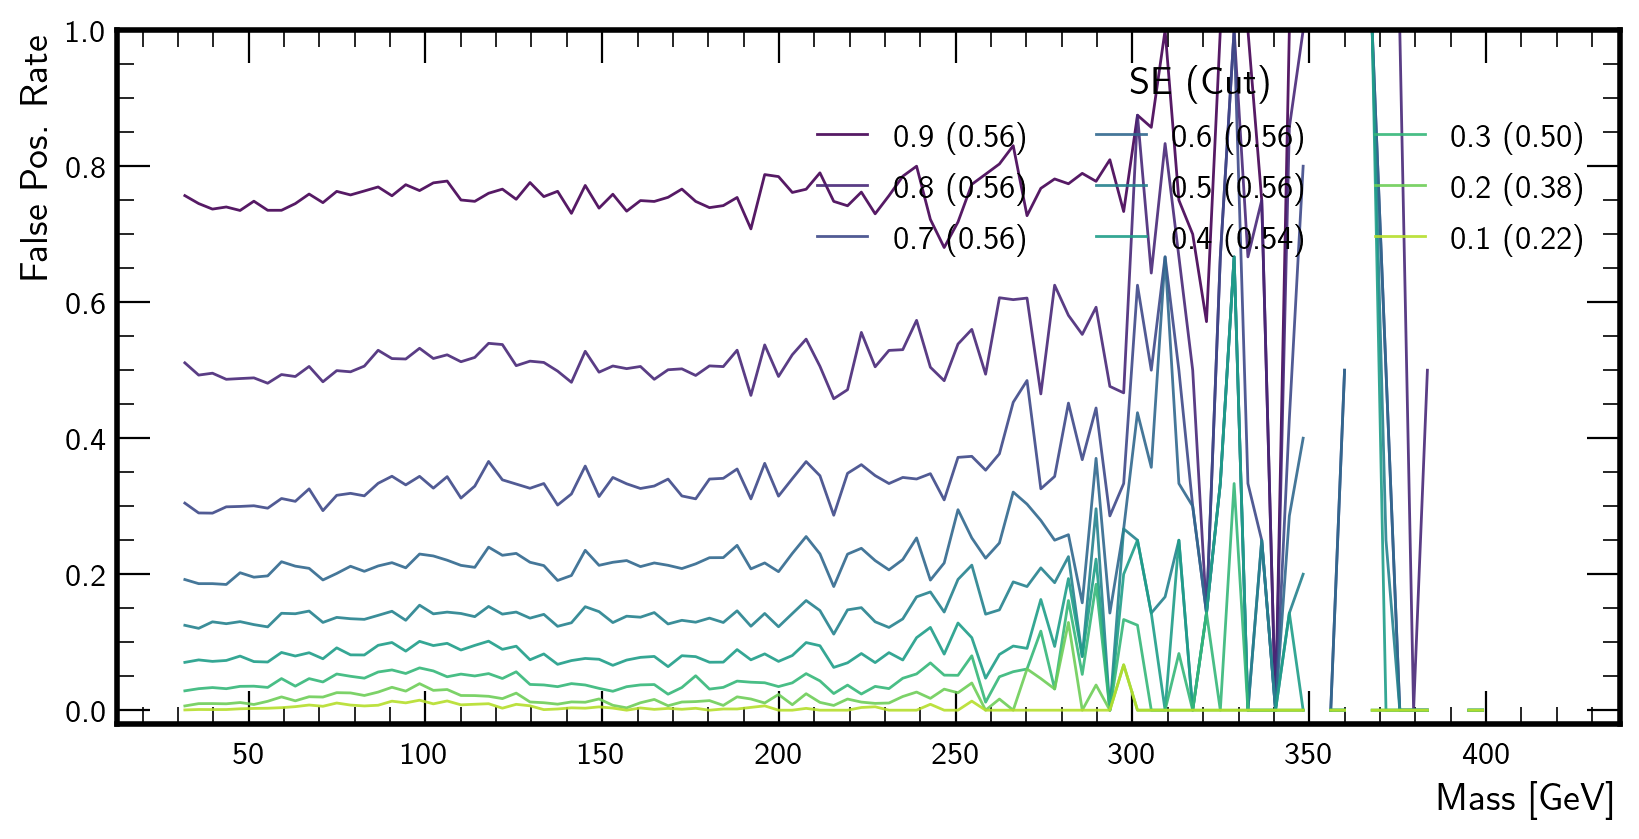

In [19]:
plot_lines(scores0,plot_path=None,show=False,mbins=100,histbins=None,dpi=200,ncuts=9,transparent=None,
           ptype=0,dynamicbins=False,scale="linear",xlim=None, ylim=[-.02,1],legend_ncol=3,cmap=plt.cm.viridis)

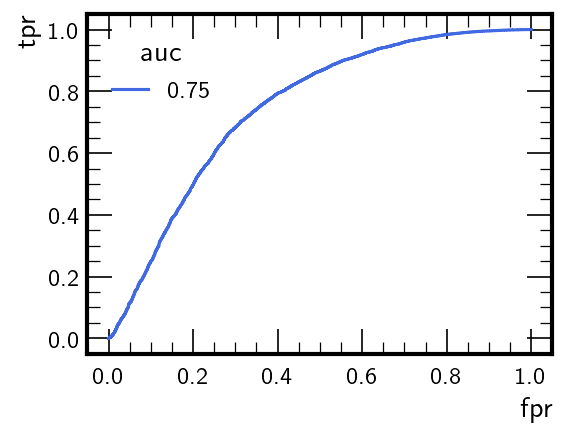

In [20]:
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
auc = roc_auc_score(y_score=scores0, y_true=test_labels)
fpr, tpr, cuts = roc_curve(y_score=scores0, y_true=test_labels)
cuts[(tpr-fpr).argmax()]
plt.plot(fpr, tpr,label=f"{auc:.2f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(title="auc")

# DisCo

In [21]:
from disco import DiscoLoss

In [22]:
# Train the NN 
disco_loss = DiscoLoss(background_only=True, background_label=1, power=1)
module_disco = Model3(dataset.samples.shape[1]) #readout_activation = torch.sigmoid)
model = Model(module_disco, optim=optim(module_disco.parameters(),lr=lr), regularization=40, regularizer = disco_loss)
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="disco",default_hp_metric=False)
path = os.path.join(logdir,f"disco/version_{log.version}")
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(model,train_dataloader=trainloader,val_dataloaders=valloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Model3 | 9.6 K 


Epoch 29: 100%|##########| 587/587 [00:17<00:00, 32.72it/s, loss=0.231, v_num=5, val_loss=0.206, val_acc=0.687, val_loss_reg=0.0242]


1

(<Figure size 800x720 with 1 Axes>,
 <AxesSubplot:xlabel='Mass [GeV]', ylabel='Counts'>)

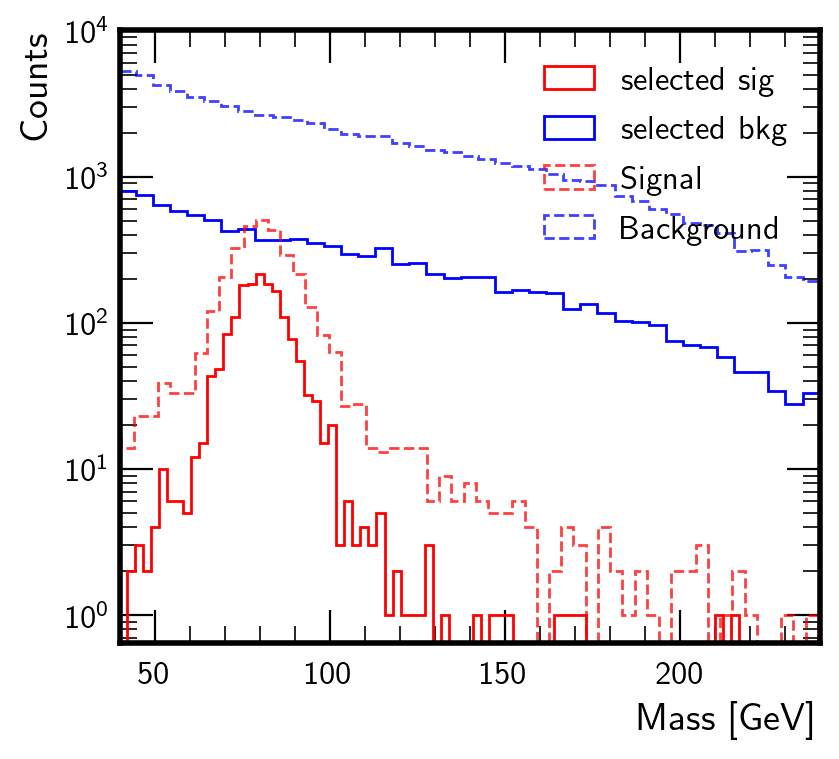

In [23]:
with torch.no_grad():
    module_disco.eval()
    scores_disco = torch.sigmoid(module_disco(test)).numpy().flatten()
cmap = plt.cm.coolwarm
plot_hists(scores_disco,c="royalblue",label="Selected",lw=None,show=True,dpi=200,transparent=False,density=False)
# plot_lines(scores,show=True,mbins=100,histbins=None,ncuts=13,dpi=200,transparent=False,
#        ptype=0,dynamicbins=True,scale=None,xlim=None,legend_ncol=0,cmap=cmap)

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered i

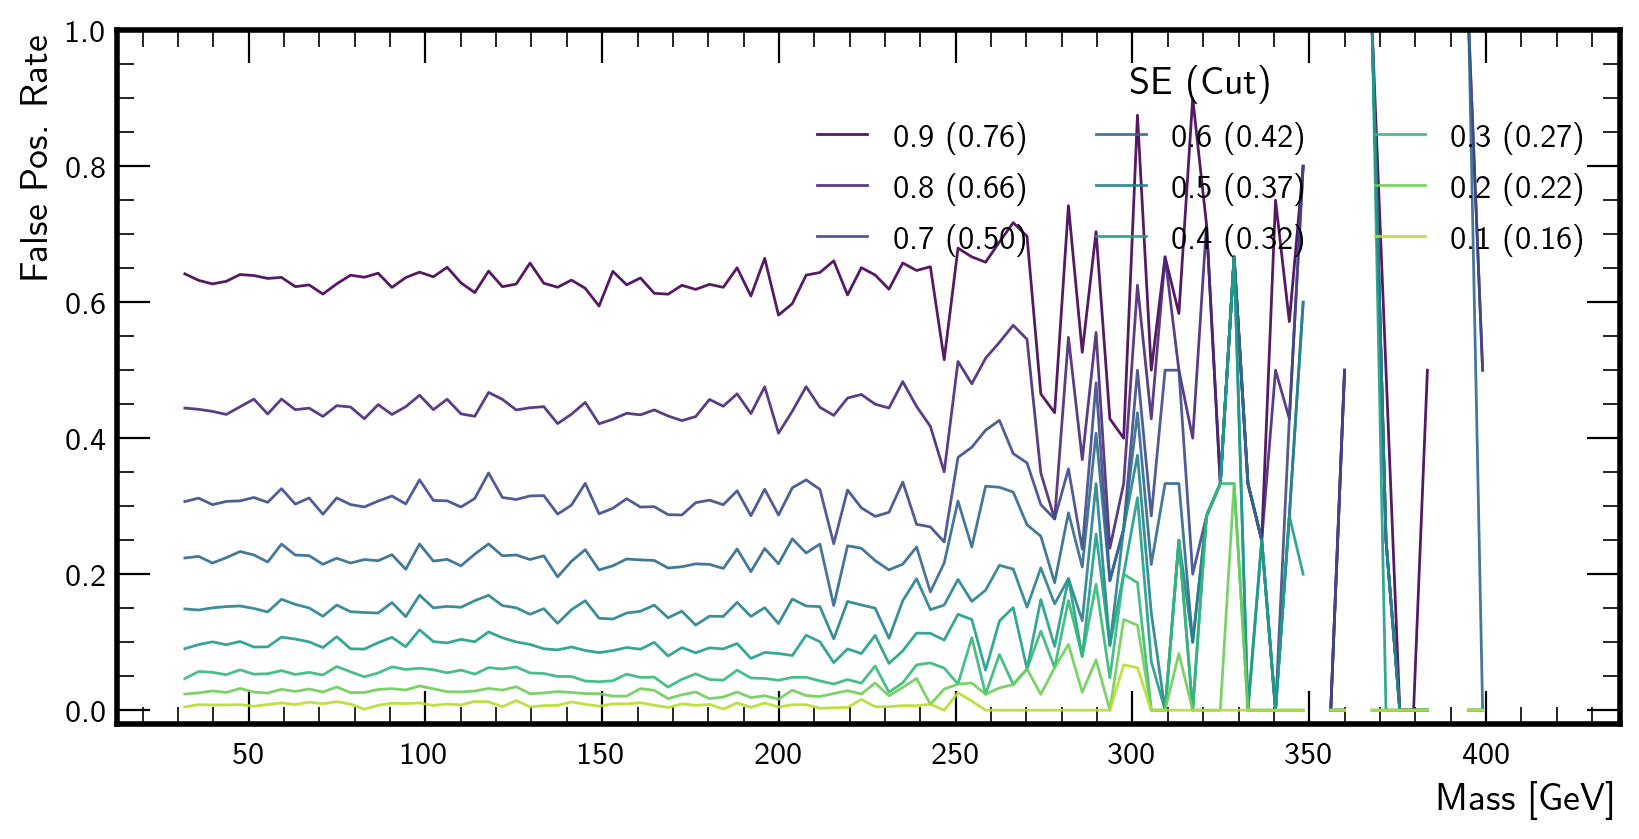

In [24]:
plot_lines(scores_disco,plot_path=None,show=False,mbins=100,histbins=None,dpi=200,ncuts=9,transparent=None,
           ptype=0,dynamicbins=False,scale="linear",xlim=None, ylim=[-.02,1],legend_ncol=3,cmap=plt.cm.viridis)

0.5765707


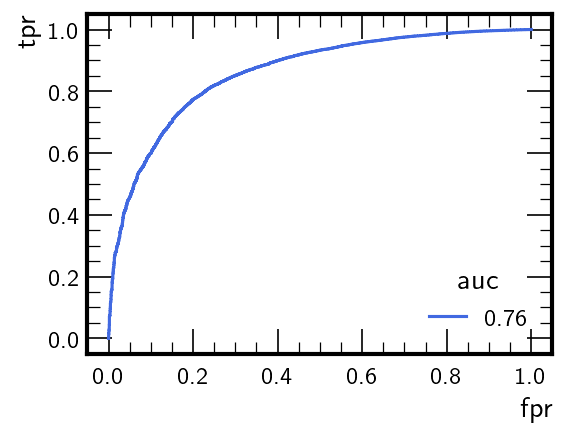

In [25]:
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
auc = roc_auc_score(y_score=scores_disco, y_true=test_labels)
fpr, tpr, cuts = roc_curve(y_score=scores, y_true=test_labels)
print(cuts[(tpr-fpr).argmax()])
plt.plot(fpr, tpr,label=f"{auc:.2f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(title="auc")

# Fitting 

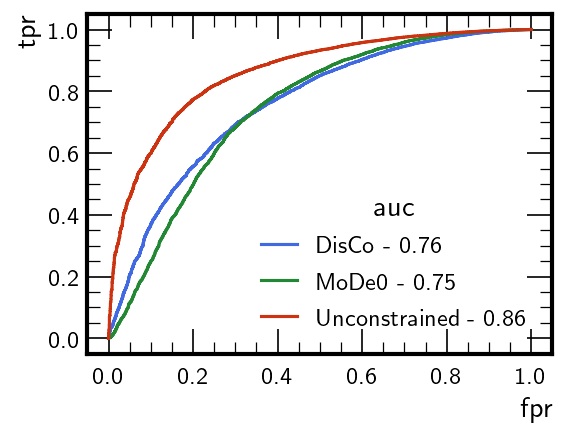

In [26]:
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
auc = roc_auc_score(y_score=scores_disco, y_true=test_labels)
fpr, tpr, cuts = roc_curve(y_score=scores_disco, y_true=test_labels)
cuts[(tpr-fpr).argmax()]
plt.plot(fpr, tpr,label=f"DisCo - {auc:.2f}")
auc = roc_auc_score(y_score=scores0, y_true=test_labels)
fpr, tpr, cuts = roc_curve(y_score=scores0, y_true=test_labels)
cuts[(tpr-fpr).argmax()]
plt.plot(fpr, tpr,label=f"MoDe0 - {auc:.2f}")
auc = roc_auc_score(y_score=scores, y_true=test_labels)
fpr, tpr, cuts = roc_curve(y_score=scores, y_true=test_labels)
cuts[(tpr-fpr).argmax()]
plt.plot(fpr, tpr,label=f"Unconstrained - {auc:.2f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(title="auc")

0.56078434


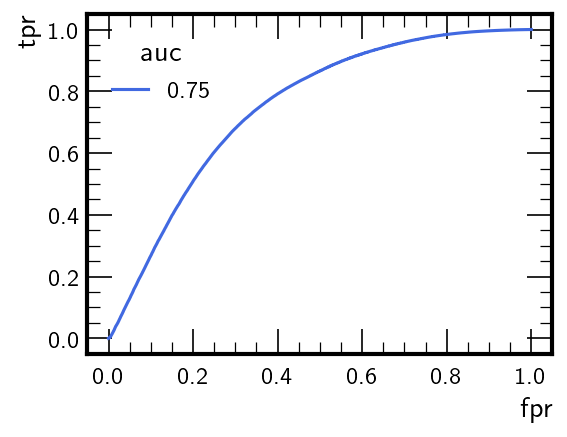

In [32]:
# get scores
all_mass = mass
all_labels = labels
all_samples = torch.from_numpy(samples)
with torch.no_grad():
    module0.eval()
    all_scores = torch.sigmoid(module0(all_samples)).numpy().flatten()
    data_scores = torch.sigmoid(module0(torch.from_numpy(data_samples))).numpy().flatten()
    z_scores = torch.sigmoid(module0(torch.from_numpy(z_samples))).numpy().flatten()
    zz_scores = torch.sigmoid(module0(torch.from_numpy(zz_samples))).numpy().flatten()
    wz_scores = torch.sigmoid(module0(torch.from_numpy(wz_samples))).numpy().flatten()
    ww_scores = torch.sigmoid(module0(torch.from_numpy(ww_samples))).numpy().flatten()
    tt_scores = torch.sigmoid(module0(torch.from_numpy(tt_samples))).numpy().flatten()
    ggh_scores = torch.sigmoid(module0(torch.from_numpy(ggh_samples))).numpy().flatten()
auc = roc_auc_score(y_score=all_scores, y_true=all_labels)
fpr, tpr, cuts = roc_curve(y_score=all_scores, y_true=all_labels)
print(cuts[(tpr-fpr).argmax()])
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
plt.plot(fpr, tpr,label=f"{auc:.2f}")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(title="auc")

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered i

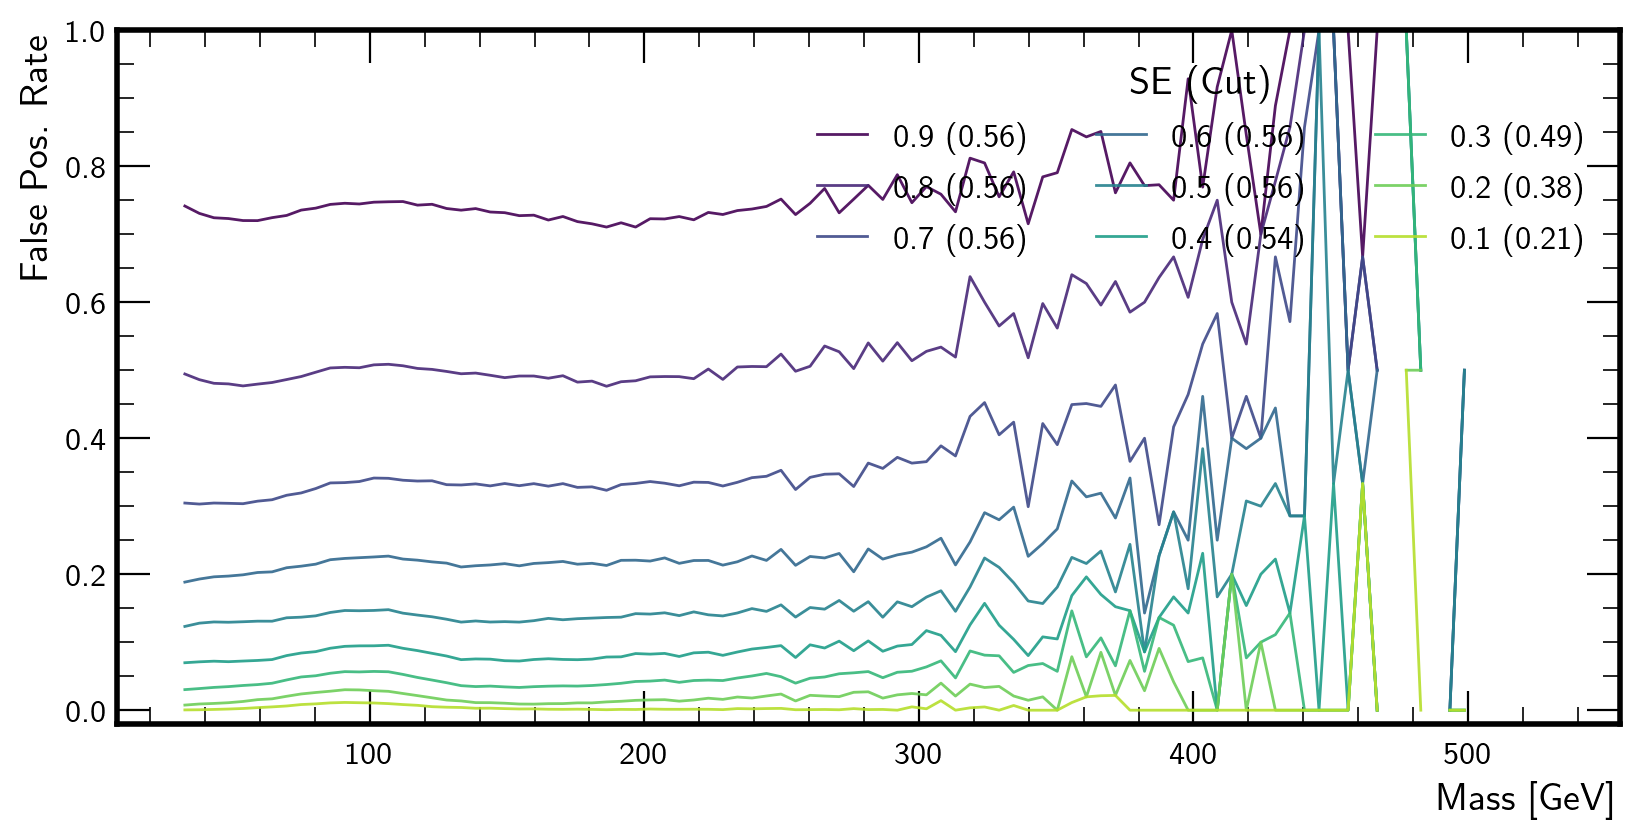

In [28]:
plot_lines(all_scores,all_mass,all_labels,plot_path=None,show=False,mbins=100,histbins=None,dpi=200,ncuts=9,transparent=None,
           ptype=0,dynamicbins=False,scale="linear",xlim=None, ylim=[-.02,1],legend_ncol=3,cmap=plt.cm.viridis)

Scale: 1.6836067433254933 14748.133987809199 8759.844925946538
Scale: 0.6932541250123121 5663.988480165775 8170.147534376638


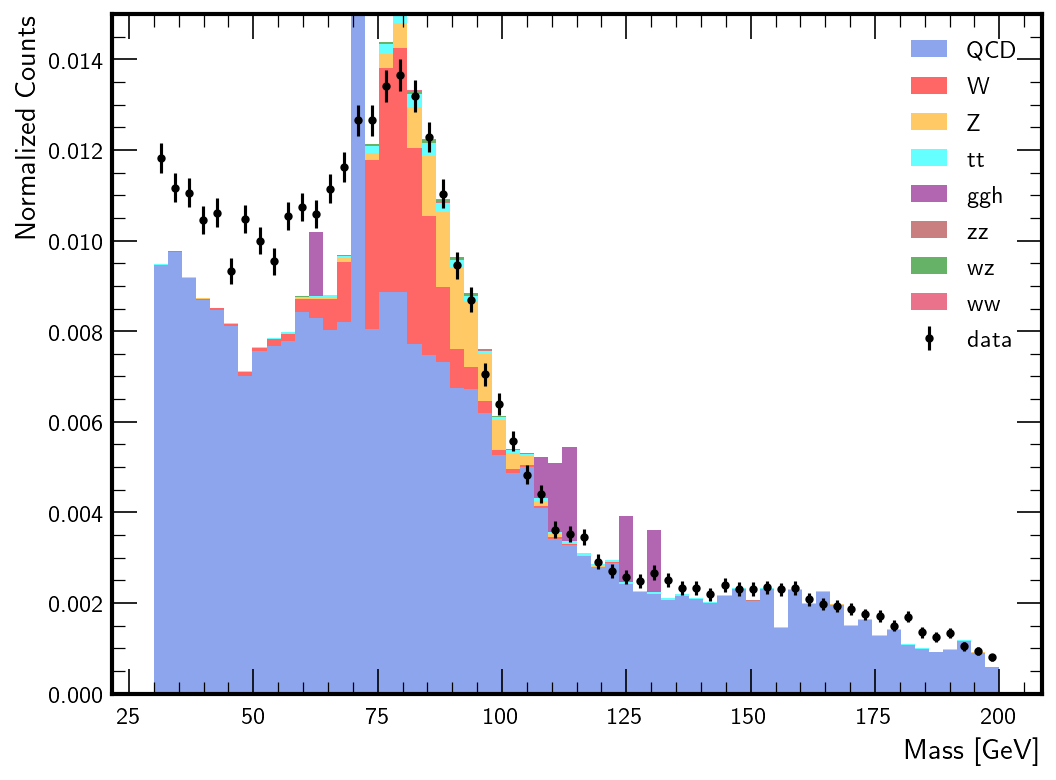

In [77]:
#Lets Look at the mass
weights=[1000*18300,"puweight","scale1fb"]
density = True
mrange, bins = (30,200), 60
cut = .47

wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)


# qcd_mask = np.zeros(len(data))
# qcd_mask[np.array(valdataset.indices)[(scores<cut)&(all_labels==1)]] = 1
# w_mask = np.zeros(len(data))
# w_mask[np.array(valdataset.indices)[(scores<cut)&(all_labels==0)]] = 1
qcd_mask = (all_scores<cut)&(all_labels==1)
w_mask = (all_scores<cut)&(all_labels==0)
z_mask = z_scores<cut
data_mask = data_scores<cut
ww_mask = ww_scores<cut
wz_mask = wz_scores<cut
zz_mask = zz_scores<cut
tt_mask = tt_scores<cut
ggh_mask = ggh_scores<cut

hist_weights = [get_weights(weights,qcd_mask),
                get_weights(weights,w_mask)*wscale,
                get_weights(weights,z_mask,sel=zsel,check=zqq13)*zscale,
                get_weights(weights,tt_mask,sel=ttsel,check=tt),
                get_weights(weights,ggh_mask,sel=gghsel,check=ggh),
                get_weights(weights,zz_mask,sel=zzsel,check=zz),
                get_weights(weights,wz_mask,sel=wzsel,check=wz),
                get_weights(weights,ww_mask,sel=wwsel,check=ww),
               ]
hists = [all_mass[(all_scores<cut)&(all_labels==1)],
         all_mass[(all_scores<cut)&(all_labels==0)],
         z_mass[z_mask],
         tt_mass[tt_mask],
         ggh_mass[ggh_mask],
         zz_mass[zz_mask],
         wz_mass[wz_mask],
         ww_mass[ww_mask],
        ]
plot_labels = ["QCD", "W", "Z", "tt", "ggh", "zz", "wz", "ww"]
plot_colors = ["royalblue",'r',"orange", "cyan", "purple", "brown", "green", "crimson"]
# plt.hist(all_mass[(scores<cut)&(all_labels==0)], bins=bins, range=mrange, alpha=0.6, label="W")
# plt.hist(all_mass[(scores<cut)&(all_labels==1)], bins=bins, range=mrange, alpha=0.6, label="QCD")
fig, ax = plt.subplots(1,1,figsize=(8,6),dpi=150)
_,bins,_ = plt.hist(hists,
         color=plot_colors, label=plot_labels, weights=hist_weights,
         range=mrange, bins=bins, alpha=.6, density=density,stacked=True)
counts, _ = np.histogram(data_mass[data_mask],bins=bins,density=density)
yerr = np.sqrt(counts) 
if density: yerr /= np.sqrt(sum(data_mask)*(bins[1]-bins[0]))
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data", ms=3)
# plt.hist(datat21, range=mrange,
#          bins=50, color='k',label="data", alpha=.6, density=density)
# plt.hist(wt21, weights=get_weights(wqq13,weights,wsel)*wscale, range=mrange,
#          bins=50, color='red',label="W", alpha=.6, density=density)
# plt.hist(zt21, weights=get_weights(zqq13,weights,zsel)*zscale, range=mrange,
#          bins=50, color='blue',label="Z", alpha=.6, density=density)
# plt.hist(ht21, weights=get_weights(ggh,weights,hsel),
#          bins=50, color='black',label="H", alpha=.6, density=True)
plt.ylim(0,0.015)
plt.legend()
plt.xlabel(r"Mass [GeV]")
plt.ylabel("Normalized Counts")
plt.show()

<ErrorbarContainer object of 3 artists>

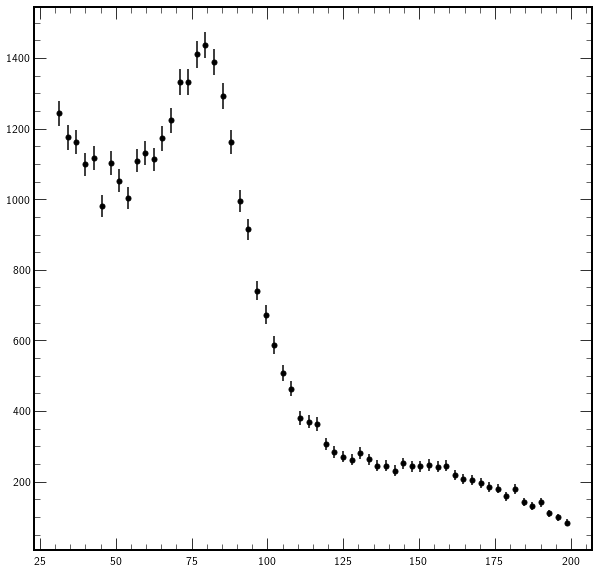

In [76]:
density = False
counts, _ = np.histogram(data_mass[data_mask],bins=bins,density=density)
yerr = np.sqrt(counts) 
if density: yerr /= np.sqrt(sum(data_mask)*(bins[1]-bins[0]))
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data", ms=5)

In [36]:
import lmfit as lm

In [63]:
bins = bins
qcdweights = get_weights(weights,qcd_mask)
zweights = get_weights(weights,z_mask,sel=zsel,check=zqq13)*zscale
counts_data, bins = np.histogram(data_mass[data_mask],bins=bins,range=mrange, density=True)
counts_qcd, bins = np.histogram(all_mass[(all_scores<cut)&(all_labels==1)],bins=bins, density=True, weights=qcdweights)
# counts_qcd, bins,_  =plt.hist([all_mass[(all_scores<cut)&(all_labels==1)],z_mass[(z_scores<cut)]], weights=[qcdweights, zweights], bins=bins, density=True, stacked=True)
# counts_qcd = counts_qcd[1]
counts = counts_data - counts_qcd
yvar = counts_data/sum(data_mask)/(bins[1]-bins[0]) + counts_qcd/sum(qcdweights)/(bins[1]-bins[0]) #+ counts_z/sum(zweights)/(bins[1]-bins[0])
w = 1/np.sqrt(abs(yvar))
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

In [64]:
#define a polynomial with a guassian note polyval is a pre-coded polynomial
def polgaus(x, p0, p1, p2, p3, a, mu, sigma):
    pols=[p0, p1, p2, p3,]
    #legendre_poly = np.polynomial.Legendre(pols)
    poly  = np.polyval(pols,x)
#     exp   = np.exp(-lambd*x)
    gauss = np.exp(-((x-mu)**2.)/(2.*sigma**2))
    y =  poly + a*gauss #+ b*exp
    return y

#define just a polynomial
def polback(x, p0, p1, p2, p3 ):
    pols=[p0,p1,p2,p3]
    y = np.polyval(pols,x)
    return y

[[Model]]
    Model(polback)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 60
    # variables        = 4
    chi-square         = 2122.4438
    reduced chi-square = 37.9007830
    Akaike info crit   = 221.958734
    Bayesian info crit = 230.336112
[[Variables]]
    p0:  1.0943e-09 +/- 2.2082e-09 (201.79%) (init = -2.9898e-09)
    p1: -3.2835e-07 +/- 8.2730e-07 (251.96%) (init = 2.0335e-06)
    p2:  2.2185e-05 +/- 9.5069e-05 (428.53%) (init = -0.00046726)
    p3:  1.5552e-04 +/- 0.00326132 (2097.03%) (init = 0.03619398)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1) = -0.994
    C(p1, p2) = -0.989
    C(p2, p3) = -0.971
    C(p0, p2) =  0.969
    C(p1, p3) =  0.930
    C(p0, p3) = -0.892


2122.4438

<Figure size 720x720 with 0 Axes>

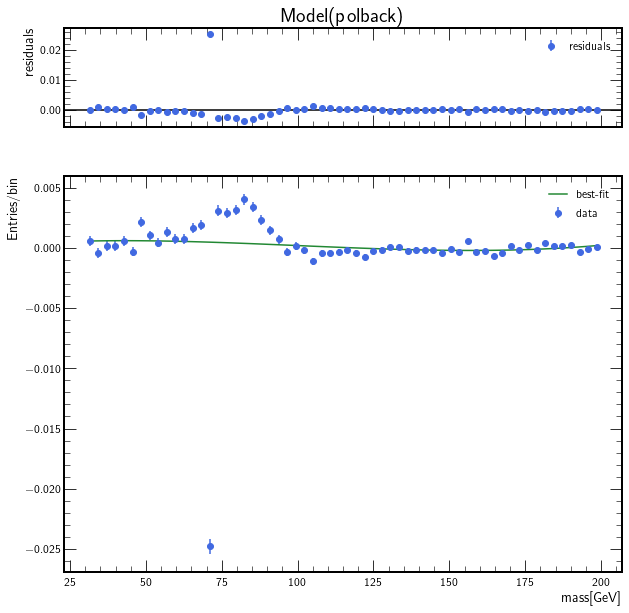

In [65]:
model = lm.Model(polback)
p = model.make_params(p0=-2.9898e-09,p1=2.0335e-06,p2=-4.6726e-04,
                      p3=0.03619398,p4=-.01,p5=.01,
                      a=1,b=-0.00188134,
                      lambd=1,mu=90,sigma=2.5)
# p["mu"].max = 200
# p["mu"].min = 40
# p["mu"].vary = True

result = model.fit(data=y, params=p, x=x, weights=w)
plt.figure()
result.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))
print(result.fit_report())
result.chisqr

[[Model]]
    Model(polgaus)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 124
    # data points      = 60
    # variables        = 7
    chi-square         = 1849.7974
    reduced chi-square = 34.9018370
    Akaike info crit   = 219.709209
    Bayesian info crit = 234.369621
[[Variables]]
    p0:    -1.0594e-09 +/- 2.3254e-09 (219.49%) (init = -1.3886e-12)
    p1:     4.7364e-07 +/- 8.7067e-07 (183.82%) (init = 1.8024e-09)
    p2:    -6.4054e-05 +/- 9.8956e-05 (154.49%) (init = -5.2497e-07)
    p3:     0.00236534 +/- 0.00327744 (138.56%) (init = 7.3652e-05)
    a:      0.00448539 +/- 0.00179284 (39.97%) (init = 1)
    mu:     83.3340093 +/- 2.20495829 (2.65%) (init = 80)
    sigma:  4.93074880 +/- 2.29635434 (46.57%) (init = 2.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1)    = -0.995
    C(p1, p2)    = -0.991
    C(p0, p2)    =  0.973
    C(p2, p3)    = -0.970
    C(p1, p3)    =  0.931
    C(p0, p3)    = -0.898
    C(a, sigma)  

1849.7974

<Figure size 720x720 with 0 Axes>

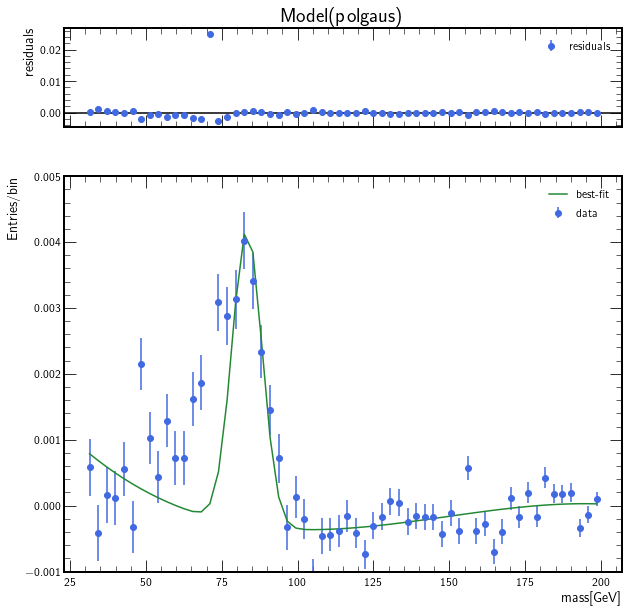

In [80]:
model = lm.Model(polgaus)
p = model.make_params(p0=-1.3886e-12,p1=1.8024e-09,p2=-5.2497e-07,
                      p3=7.3652e-05,p4=-0.00503250,p5=0.14118380,
                      a=1,mu=80,sigma=2.5)
p["mu"].max = 200
p["mu"].min = 40
p["mu"].vary = True
p["sigma"].max = 0
p["sigma"].min = 10

result = model.fit(data=y, params=p, x=x, weights=w)
plt.figure()
result.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))
plt.ylim([-.001,.005])
print(result.fit_report())
result.chisqr

[[Model]]
    Model(polgaus)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 124
    # data points      = 60
    # variables        = 7
    chi-square         = 1849.7974
    reduced chi-square = 34.9018370
    Akaike info crit   = 219.709209
    Bayesian info crit = 234.369621
[[Variables]]
    p0:    -1.0594e-09 +/- 2.3254e-09 (219.49%) (init = -1.3886e-12)
    p1:     4.7364e-07 +/- 8.7067e-07 (183.82%) (init = 1.8024e-09)
    p2:    -6.4054e-05 +/- 9.8956e-05 (154.49%) (init = -5.2497e-07)
    p3:     0.00236534 +/- 0.00327744 (138.56%) (init = 7.3652e-05)
    a:      0.00448539 +/- 0.00179284 (39.97%) (init = 1)
    mu:     83.3340093 +/- 2.20495829 (2.65%) (init = 80)
    sigma:  4.93074880 +/- 2.29635434 (46.57%) (init = 2.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1)    = -0.995
    C(p1, p2)    = -0.991
    C(p0, p2)    =  0.973
    C(p2, p3)    = -0.970
    C(p1, p3)    =  0.931
    C(p0, p3)    = -0.898
    C(a, sigma)  

1849.7974

<Figure size 720x720 with 0 Axes>

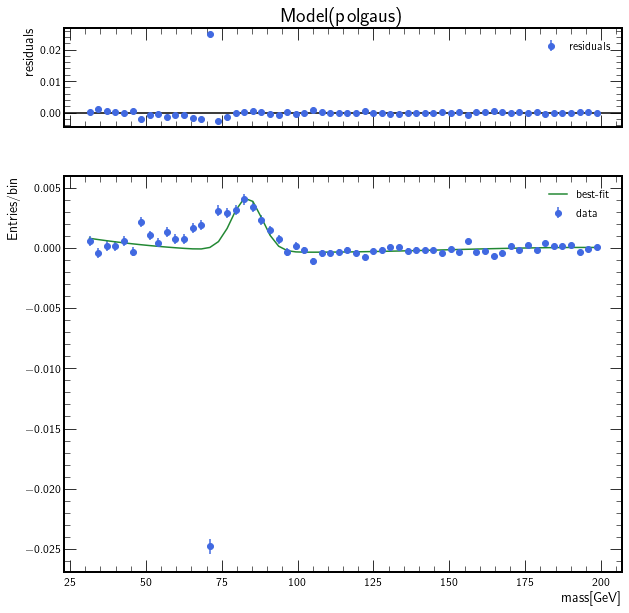

In [66]:
model = lm.Model(polgaus)
p = model.make_params(p0=-1.3886e-12,p1=1.8024e-09,p2=-5.2497e-07,
                      p3=7.3652e-05,p4=-0.00503250,p5=0.14118380,
                      a=1,mu=80,sigma=2.5)
p["mu"].max = 200
p["mu"].min = 40
p["mu"].vary = True
p["sigma"].max = 0
p["sigma"].min = 10

result = model.fit(data=y, params=p, x=x, weights=w)
plt.figure()
result.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))
print(result.fit_report())
result.chisqr